In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.research import run_pipeline
from quantopian.pipeline.data import morningstar, Fundamentals
from quantopian.pipeline.factors import CustomFactor,AverageDollarVolume,SimpleMovingAverage, ExponentialWeightedMovingAverage, EWMA
from quantopian.pipeline.filters.morningstar import IsPrimaryShare
from quantopian.pipeline.factors import AverageDollarVolume
from quantopian.pipeline.factors.morningstar import MarketCap
from quantopian.pipeline.experimental import QTradableStocksUS
from statsmodels.tsa.stattools import coint
from scipy import stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import scipy
import statsmodels.api as sm

In [2]:
def make_pipe(start,end):        
    mcap = MarketCap()
    min_mcap = mcap > 5e10
    
    price = USEquityPricing.close.latest
    can_trade = QTradableStocksUS()
    sector = Sector()
    
    asset_filter = can_trade & min_mcap
    pipe = Pipeline(screen = asset_filter)

    pipe.add(price,'price')
    pipe.add(sector,"Sector")
    

    res2 = run_pipeline(pipe, start, end)
    return res2

In [3]:
MORNINGSTAR_SECTOR_CODES = {  
     -1: 'Misc',  
    101: 'Basic Materials',  
    102: 'Consumer Cyclical',  
    103: 'Financial Services',  
    104: 'Real Estate',  
    205: 'Consumer Defensive',  
    206: 'Healthcare',  
    207: 'Utilities',  
    308: 'Communication Services',  
    309: 'Energy',  
    310: 'Industrials',  
    311: 'Technology' ,  
}

In [99]:
end = datetime.datetime.now()  - datetime.timedelta(3)
start = datetime.datetime.now() - datetime.timedelta(9)
result = make_pipe(start,end)

In [100]:
date = result.index[0][0]

companies = []
for company in result.loc[date]['Sector'].index:
#     if result.loc[date]['Sector'][company] ==  311:
#     if result.loc[date]['Sector'][company] ==  206:
    if result.loc[date]['Sector'][company] ==  310:
        companies.append(company)

In [101]:
companies

[Equity(630 [ADP]),
 Equity(698 [BA]),
 Equity(1267 [CAT]),
 Equity(1937 [CSX]),
 Equity(2765 [FDX]),
 Equity(3136 [GD]),
 Equity(3149 [GE]),
 Equity(4922 [MMM]),
 Equity(7800 [UNP]),
 Equity(7883 [UTX]),
 Equity(12691 [LMT]),
 Equity(16178 [CNI]),
 Equity(20940 [UPS]),
 Equity(25090 [HON])]

In [102]:
prices = get_pricing(companies, start_date=start, end_date=end, frequency='minute', fields='price')

In [118]:
coints = []
corrs = []
print coint(prices[companies[c1]],prices[companies[c2]])
for c1 in range(len(companies)):
    for c2 in range(c1,len(companies)):
        if c1==c2: continue
        coints.append(coint(prices[companies[c1]],prices[companies[c2]])[0])
        corrs.append(np.corrcoef(prices[companies[c1]],prices[companies[c2]])[0][1])
        print(c1,c2,coints[-1])

(-3.3510851263954229, 0.048081299409769906, array([-3.43454878, -2.86339451, -2.56775731]))
(0, 1, -2.3524960163452948)
(0, 2, -4.4760011271437259)
(0, 3, -1.788476823667015)
(0, 4, -3.111409599040881)
(0, 5, -4.2401234985184661)
(0, 6, -2.5298840589042806)
(0, 7, -4.5209641906330411)
(0, 8, -2.5457319779035941)
(0, 9, -4.3741997782046909)
(0, 10, -3.4737957208722245)
(0, 11, -3.7828349078209267)
(0, 12, -2.8848756064592367)
(0, 13, -1.8086863290065729)
(1, 2, -2.8934090280126035)
(1, 3, -2.928180410919945)
(1, 4, -4.3393704157457993)
(1, 5, -3.4850902409989635)
(1, 6, -3.2931456730536715)
(1, 7, -3.0495588823522)
(1, 8, -3.0020744729459112)
(1, 9, -3.1710395912873888)
(1, 10, -2.8981232637888295)
(1, 11, -3.3511549341471198)
(1, 12, -3.1766692158421375)
(1, 13, -3.1926935324449821)
(2, 3, -1.6719581358909146)
(2, 4, -2.7780817629886156)
(2, 5, -4.5579306774014681)
(2, 6, -3.330410310879429)
(2, 7, -5.8787310123319489)
(2, 8, -2.8179785417529812)
(2, 9, -2.7455428966109157)
(2, 10, -3.

In [104]:
print(np.mean(coints),np.mean(corrs))

(-3.2581984769670527, 0.14606307655138506)


In [105]:
def backtest(pr,max_pos=1,num_factors=1,initial_cash=1e6,lkbk=500):
    entry = {}
    pnls = []
    #resids = run_pca(pr,num_factors)
    
    if max_pos > pr.shape[0]/2:
        print('max_pos too large!')
        return

    for i,pri in enumerate(pr.T):

        if i < 60: continue
 
        resids, factors = run_pca(pr[:,max(0,i-lkbk):i],num_factors,log_prices=True)
        zs = {}
        for inst in range(len(pri)):
            #zs[inst] = Zscore(resids[inst])[i]
            zs[inst] = Zscore(resids[inst])[-1]

        idx_long = (np.argsort([zs[j] for j in zs])[:max_pos])
        idx_short = (np.argsort([zs[j] for j in zs])[-max_pos:])
        
        pnl = 0
        for j,idx in enumerate(entry):
            wgt = np.round((initial_cash/len(pri))/entry[idx])
            #pnl += ((pri[idx]-np.abs(entry[idx]))/np.abs(entry[idx]))*wgt/initial_cash
            pnl += ((pri[idx]-np.abs(entry[idx])))*wgt
            #print pnl
        pnls.append(pnl)
            
        entry = {}
        

        #print(idx_long, idx_short)
        for idx in idx_long:
            entry[idx] = pri[idx]
        for idx in idx_short:
            entry[idx] = -pri[idx]
        #print(i,entry)
        
        print(i,sum(pnls))
    return(pnls)

In [106]:
def Zscore(X):
    return np.array((X - np.mean(X)) / np.std(X))

In [107]:
def run_pca(pr,components=1,log_prices=True):
    pca = PCA(n_components=components)
    if log_prices:
        comps = pca.fit(np.log(pr.T)).components_.T
    else:
        comps = pca.fit(pr.T).components_.T
    factors = sm.add_constant(pr.T.dot(comps))
    mm = [sm.OLS(s.T, factors).fit() for s in pr]
    resids = list(map(lambda x: x.resid, mm))
    return resids, factors

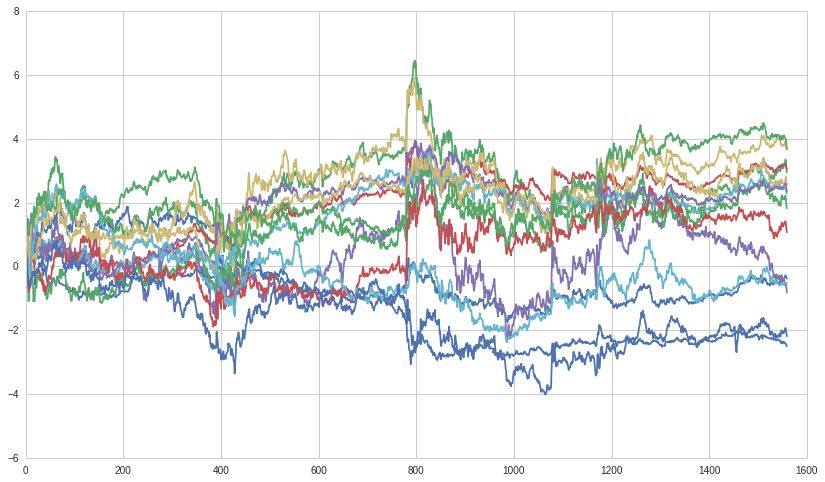

In [108]:
for p in np.asarray(prices.T):
    plt.plot((p-p[0])/np.std(p))

In [116]:
pnls = backtest(np.asarray(prices.T),max_pos=5,num_factors=3,initial_cash=1e6,lkbk=500)

(60, 0)
(61, 67.565000000018216)
(62, 54.48100000004932)
(63, 157.78100000003809)
(64, 417.17200000003919)
(65, 761.6820000000339)
(66, 700.75000000004206)
(67, 938.60400000003108)
(68, 1102.2450000000433)
(69, 905.77000000006421)
(70, 741.58400000006134)
(71, 638.66500000007613)
(72, 698.24100000008582)
(73, 1109.4670000000954)
(74, 653.21300000010376)
(75, 655.81000000008896)
(76, 671.27500000007717)
(77, 1114.10600000006)
(78, 1101.0340000000538)
(79, 974.60800000007384)
(80, 1167.803000000092)
(81, 1217.5430000000656)
(82, 1177.8290000000638)
(83, 1328.9350000000711)
(84, 1587.189000000079)
(85, 1622.4140000000589)
(86, 1860.8830000000871)
(87, 1983.456000000042)
(88, 1914.0700000000579)
(89, 1686.9540000000645)
(90, 1401.3940000000348)
(91, 1306.8160000000435)
(92, 1010.0810000000561)
(93, 1030.3810000000535)
(94, 1254.7880000000373)
(95, 1401.1540000000512)
(96, 832.1890000000368)
(97, 943.18900000004862)
(98, 833.12800000003358)
(99, 902.17000000005646)
(100, 1079.1100000000561)

(382, 2962.3539999999639)
(383, 2851.1539999999604)
(384, 2840.1939999999613)
(385, 2863.7239999999679)
(386, 2778.4139999999425)
(387, 2480.1539999999673)
(388, 2666.5089999999545)
(389, 3061.1739999999372)
(390, 1941.4199999999482)
(391, 2696.2369999999578)
(392, 3558.6269999999504)
(393, 3936.8389999999577)
(394, 4116.0819999999494)
(395, 3943.9139999999265)
(396, 3537.3179999999484)
(397, 3765.8129999999569)
(398, 3702.4069999999674)
(399, 4226.8349999999873)
(400, 3507.394999999955)
(401, 3954.7409999999504)
(402, 3694.3039999999814)
(403, 4023.8159999999621)
(404, 4149.9759999999624)
(405, 4274.8959999999488)
(406, 3881.1919999999614)
(407, 3832.099999999974)
(408, 3548.9529999999559)
(409, 3458.4129999999655)
(410, 3451.9979999999869)
(411, 3350.8569999999745)
(412, 3188.2279999999782)
(413, 3023.0889999999918)
(414, 3222.7359999999853)
(415, 3224.1779999999517)
(416, 3246.7489999999698)
(417, 3049.8059999999819)
(418, 3133.4309999999941)
(419, 3044.9009999999962)
(420, 2535.849

(710, 3964.511999999962)
(711, 3957.9219999999659)
(712, 3883.1469999999599)
(713, 3580.1579999999749)
(714, 3829.6199999999585)
(715, 4055.0459999999543)
(716, 4137.9819999999208)
(717, 4192.2709999999315)
(718, 4327.4629999999524)
(719, 4304.8979999999483)
(720, 4270.2179999999289)
(721, 4324.7449999999471)
(722, 4350.2109999999557)
(723, 4227.7819999999301)
(724, 4281.0789999999406)
(725, 4401.855999999937)
(726, 4412.1459999999452)
(727, 4418.5999999999603)
(728, 4320.3969999999581)
(729, 4360.5129999999526)
(730, 4373.7529999999506)
(731, 4335.2779999999439)
(732, 4390.7429999999595)
(733, 4425.7979999999679)
(734, 4445.1569999999492)
(735, 4439.7609999999659)
(736, 4299.3759999999393)
(737, 4167.9559999999647)
(738, 3999.2649999999576)
(739, 3934.6859999999433)
(740, 4066.3909999999637)
(741, 3982.632999999948)
(742, 3992.6929999999461)
(743, 3987.020999999942)
(744, 3939.0859999999716)
(745, 3861.0409999999551)
(746, 3843.0299999999606)
(747, 3893.7109999999602)
(748, 3691.01999

(1034, 2646.1499999999105)
(1035, 2581.7329999999297)
(1036, 2724.0709999999463)
(1037, 2731.7759999999357)
(1038, 2723.1639999999211)
(1039, 2672.0389999999247)
(1040, 2564.8789999999167)
(1041, 2577.7499999999181)
(1042, 2549.0649999999137)
(1043, 2575.0649999999114)
(1044, 2616.6249999999281)
(1045, 2554.1629999999363)
(1046, 2339.7659999999405)
(1047, 2339.7199999999375)
(1048, 2327.5159999999255)
(1049, 2257.0659999999298)
(1050, 2095.2589999999282)
(1051, 2086.2019999999384)
(1052, 2142.5979999999145)
(1053, 1959.6509999999128)
(1054, 2024.3009999999108)
(1055, 1976.8779999999067)
(1056, 2101.3979999999174)
(1057, 2220.0159999999237)
(1058, 2138.2729999999237)
(1059, 2013.7079999999441)
(1060, 1902.2569999999353)
(1061, 1851.7669999999177)
(1062, 1703.5269999999546)
(1063, 1654.5589999999338)
(1064, 1615.8169999999552)
(1065, 1559.6869999999144)
(1066, 1739.3319999999144)
(1067, 1559.9339999999527)
(1068, 1543.6889999999446)
(1069, 1480.9339999999449)
(1070, 1261.5239999999462)
(

(1358, 10117.768000000096)
(1359, 10171.693000000083)
(1360, 10167.529000000093)
(1361, 10254.980000000101)
(1362, 10136.879000000079)
(1363, 10130.482000000102)
(1364, 10087.903000000062)
(1365, 10042.978000000085)
(1366, 9907.8990000000722)
(1367, 9890.9140000000643)
(1368, 9906.9170000000613)
(1369, 10038.737000000074)
(1370, 9963.0560000000623)
(1371, 9930.999000000058)
(1372, 9963.2070000000276)
(1373, 9885.2820000000665)
(1374, 10012.632000000085)
(1375, 9942.2720000000718)
(1376, 9892.0020000000568)
(1377, 9919.9390000000421)
(1378, 9843.6480000000629)
(1379, 9729.4730000000454)
(1380, 9697.2990000000518)
(1381, 9756.3630000000539)
(1382, 9867.6790000000419)
(1383, 9838.3860000000604)
(1384, 9817.5350000000453)
(1385, 9986.3630000000594)
(1386, 10070.139000000054)
(1387, 10025.304000000044)
(1388, 9994.5050000000483)
(1389, 9915.9630000000398)
(1390, 9759.392000000078)
(1391, 9856.8150000000551)
(1392, 9817.4950000000499)
(1393, 9831.1430000000528)
(1394, 9639.844000000041)
(139

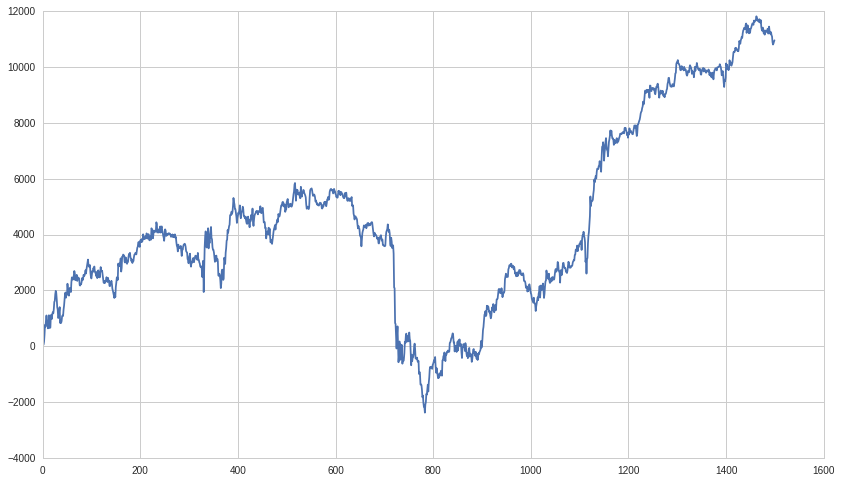

In [117]:
plt.plot(np.cumsum(pnls))